# Comparing a USGSCSM and ISIS camera for Cassini ISS NAC

In [1]:
import os 
import sys

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json
import pvl

import ale
from ale import util
from ale.drivers.co_drivers import CassiniIssPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm
from ale.drivers import AleJsonEncoder

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Fetch the test image

In [2]:
imageLink = 'https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2038/data/1573076626_1573088441/N1573082850_1.IMG'
lblLink = os.path.splitext(imageLink)[0] + '.LBL'
!wget -N -P data/ {imageLink}
!wget -N -P data/ {lblLink}
fileName = 'data/' + os.path.split(lblLink)[1]

--2019-10-30 14:24:33--  https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2038/data/1573076626_1573088441/N1573082850_1.IMG
Resolving pds-imaging.jpl.nasa.gov... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File 'data/N1573082850_1.IMG' not modified on server. Omitting download.

--2019-10-30 14:24:34--  https://pds-imaging.jpl.nasa.gov/data/cassini/cassini_orbiter/coiss_2038/data/1573076626_1573088441/N1573082850_1.LBL
Resolving pds-imaging.jpl.nasa.gov... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File 'data/N1573082850_1.LBL' not modified on server. Omitting download.



## Ingest the image, spiceinit, and create a usgscsm sensor model

In [ ]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.ciss2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)
    
kernels = util.get_kernels_from_isis_pvl(pvl.load(cub_loc)["IsisCube"], format_as="list")

# Isis doesn't ship IK kernels
cassini_ik_kernel = os.path.join(ale.spice_root, "co-s_j_e_v-spice-6-v1.0", "cosp_1000", "data", "ik", "cas_iss_v10.ti")
kernels.insert(0, cassini_ik_kernel)    

In [6]:
with CassiniIssPds3LabelNaifSpiceDriver(fileName, props={"kernels":kernels}) as driver:
    usgscsm_dict = to_usgscsm(driver)
    csm_isd = os.path.splitext(fileName)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'), cls=AleJsonEncoder)
camera = knoten.csm.create_csm(fileName)

In [7]:
usgscsm_dict

{'radii': {'semimajor': 60268.0, 'semiminor': 54364.0, 'unit': 'km'},
 'sensor_position': {'positions': [array([-5.79877205e+08, -2.88110395e+09,  1.65490446e+08])],
  'velocities': [array([-4.70440169e+05,  9.52179734e+04,  6.08071687e+01])],
  'unit': 'm'},
 'sun_position': {'positions': array([[-1.00624634e+12, -9.20218774e+11, -2.37280888e+11]]),
  'velocities': array([[-1.50712799e+08,  1.64800625e+08,  4.05311739e+03]]),
  'unit': 'm'},
 'sensor_orientation': {'quaternions': array([[ 0.46171505, -0.55773176, -0.44086276, -0.53046632]])},
 'detector_sample_summing': 1,
 'detector_line_summing': 1,
 'focal_length_model': {'focal_length': 2002.66},
 'detector_center': {'line': 512, 'sample': 512},
 'starting_detector_line': 0,
 'starting_detector_sample': 0,
 'focal2pixel_lines': [0.0, 0.0, 83.33333333333333],
 'focal2pixel_samples': [0.0, 83.33333333333333, 0.0],
 'optical_distortion': {'radial': {'coefficients': [0, -8e-06, 0]}},
 'image_lines': 1024,
 'image_samples': 1024,
 'nam

In [8]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

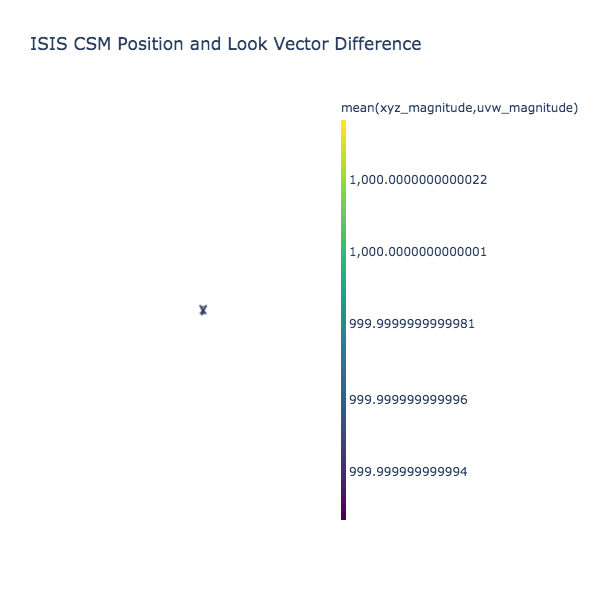

In [9]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

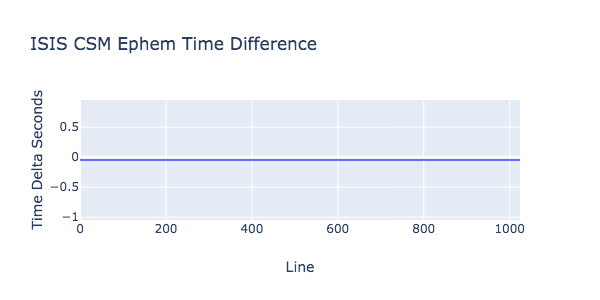

In [10]:
Image(csmisis_diff_ephem_plot_bytes)

In [11]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000
mean,21842.089327,-4420.96613,-2.823236,-184.495742,-980.631947,48.135941
std,0.000000,0.00000,0.000000,1.740935,0.338024,1.762599
min,21842.089327,-4420.96613,-2.823236,-187.478077,-981.312607,45.370389
25%,21842.089327,-4420.96613,-2.823236,-186.000517,-980.916042,46.603842
50%,21842.089327,-4420.96613,-2.823236,-184.495602,-980.632799,48.135898
75%,21842.089327,-4420.96613,-2.823236,-182.991636,-980.351142,49.668331
max,21842.089327,-4420.96613,-2.823236,-181.511886,-979.941108,50.900674


In [12]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 10, 500, 500)

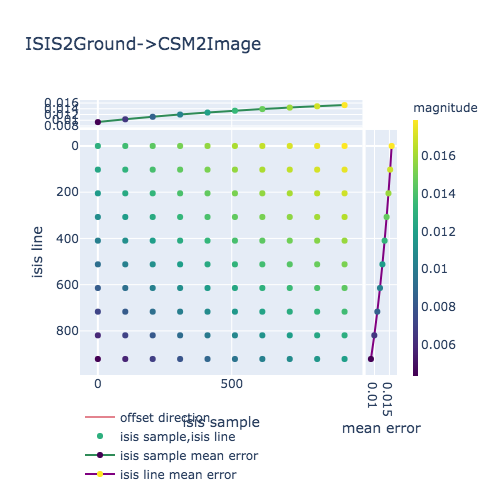

In [13]:
Image(isis2csm_plot.to_image())

In [14]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,-0.012688,0.000971
std,0.002946,0.000114
min,-0.017917,0.000770
25%,-0.014975,0.000873
50%,-0.012967,0.000970
75%,-0.010944,0.001064
max,-0.004239,0.001202


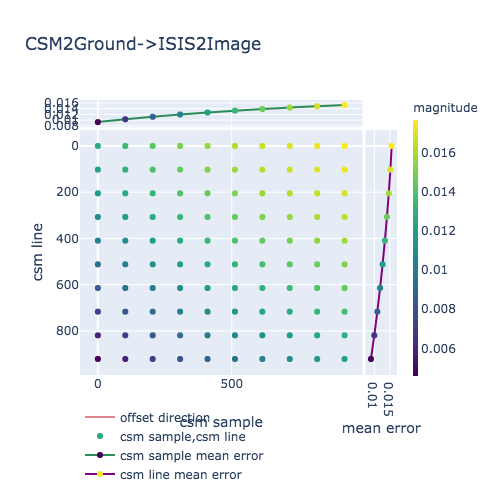

In [22]:
Image(csm2isis_plot.to_image())

In [16]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,0.012670,-0.000988
std,0.002905,0.000123
min,0.004440,-0.001340
25%,0.010916,-0.001080
50%,0.012930,-0.000997
75%,0.014944,-0.000904
max,0.017666,-0.000624


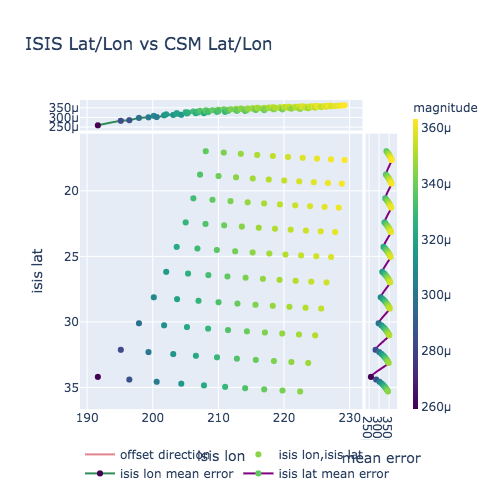

In [17]:
Image(isiscsm_plotlatlon.to_image())

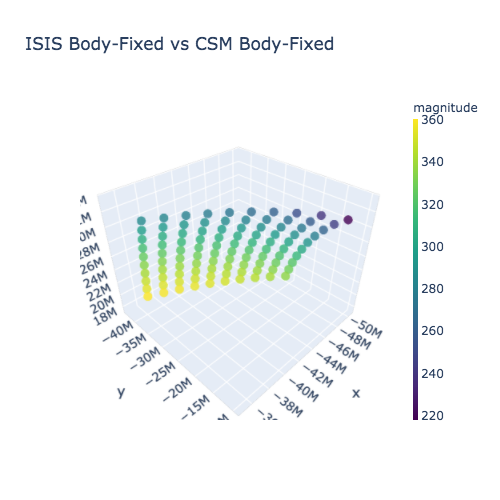

In [21]:
Image(isiscsm_plotbf.to_image())

In [19]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,100.000000,100.000000,100.000000
mean,0.026806,254.922014,6.819969
std,0.003517,20.559322,0.897038
min,0.023896,213.524428,5.710395
25%,0.024672,238.514836,6.076171
50%,0.025789,253.136566,6.669744
75%,0.027327,271.118609,7.389427
max,0.046513,297.483002,9.994823
